## Evaluation of wind source in Finland by using FMI wind speed observations in terms of suitable fractions of a year to run household appliances within specified waiting tolerances.
**Optional data sources:**
- **FMI**: 200+ FMI stations, observation data.
- **ERA5**: Reanalysis combines model data with observations from across the world into a globally complete and consistent dataset from January 1940 to present. The spatial resolution is 0.25*0.25 degree, and temporal resolution is 1 hour. 
- **NEWA**(New European Wind Atlas):  This dataset covers the entire EU plus Turkey and 100 km offshore as well as the complete North and Baltic Seas, with a 3 km grid spacing and 30 mins temporal resolution, and a coverage of 30 years (1989-2018). 

In [13]:
from mpl_toolkits.basemap import Basemap  # import Basemap matplotlib toolkit
import warnings
warnings.filterwarnings('ignore')

In [14]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import pickle
import json
import os

## Wind Turbines and Wind to Power Transformation Methods/Functions

In [15]:
# %load config.py
from windpowerlib import WindTurbine
import pandas as pd

# specification of own wind turbine (Note: power curve values and nominal power have to be in Watt)  
# My backyard turbine: Automaxx Windmill 1500W 48V 60A Home Wind Turbine
my_turbine = {
    'nominal_power': 3e6,  # in W
    'hub_height': 10,  # in m
    'power_curve': pd.DataFrame(
        data={'value': [
            0.0, 40.0, 60.0, 105.1, 400.0, 600.0, 900.0,1500.0],  # in W
            'wind_speed': [0.0, 3.0, 4.5, 5.0, 6.5, 7.5, 10, 14]})  # in m/s
}
# initialize WindTurbine object
my_turbine = WindTurbine(**my_turbine)

# Camping turbine (windcharger)
rutland504 = {
    'nominal_power': 3e6,  # in W
    'hub_height': 10,  # in m
    'power_curve': pd.DataFrame(
        data={'value': [
            0.0, 0.0, 3.0, 11.1, 29.0, 39.0],  # in W
            'wind_speed': [0.0, 3.0, 5.1, 7.0, 11.0, 13.0]})  # in m/s
}
# initialize WindTurbine object
rutland504 = WindTurbine(**rutland504)


n100 = {
    'hub_height': 100,
    'turbine_type': 'N100/2500'}
n100 = WindTurbine(**n100)


e48 = {
    'hub_height': 100,
    'turbine_type': 'E48/800'}
e48 = WindTurbine(**e48)


In [16]:
# %load wind_power_transformation.py
import pandas as pd
import numpy as np

from windpowerlib import ModelChain, WindTurbine, create_power_curve, wind_speed

def hellman(
    wind_speed,
    wind_speed_height,
    hub_height,
    roughness_length=None,
    hellman_exponent=None
):
    hellman_exponent = 1 / 7
    return wind_speed * (hub_height / wind_speed_height) ** hellman_exponent


wind_speed.hellman = hellman


def speed_to_power(weather_df, my_turbine):

    mc_my_turbine = ModelChain(
        my_turbine,
        power_output_model='power_curve',
        wind_speed_model='hellman')
    mc_my_turbine.run_model(weather_df)
    # write power output time series to WindTurbine object
    my_turbine.power_output = mc_my_turbine.power_output.values
    return my_turbine.power_output

## Map Generating Function

In [17]:
def draw_power_map(data, country='Finland', indicator='marker_size'):
    fig, ax = plt.subplots(figsize=(15, 10))
    if country == 'Finland':
        # the territory of Finland
        m = Basemap(projection='lcc', resolution='l',
                    lat_0=64.8238, lon_0=28.2179,
                    width=1.05E6, height=1.4E6)
    m.shadedrelief()
    m.drawcountries(color='gray', linewidth=1)
    m.drawstates(color='gray')

    x, y = m(data["longitude"].to_numpy(),
             data["latitude"].to_numpy())  # transform coordinates
    markersize = data['fraction']
    opacity = data['fraction']
    if indicator == 'marker_size':
        ax.scatter(x, y, s=markersize*100, marker='o', facecolors='r',
                   edgecolors='darkred')
    else:
        ax.scatter(x, y, s=80, marker='o', facecolors='r',
                   edgecolors='darkred', alpha=opacity)
    gs = plt.scatter([], [], s=0.2*100, marker='o', facecolors='r',
                     edgecolors='darkred')

    gm = plt.scatter([], [], s=0.5*100, marker='o', facecolors='r',
                     edgecolors='darkred')
    gl = plt.scatter([], [], s=1.0*100, marker='o', facecolors='r',
                     edgecolors='darkred')
    plt.legend((gs, gm, gl),
               ('0.2', '0.5', '1.0'),
               #    scatterpoints=1,
               loc='lower right',
               ncol=1,
               fontsize=8)
    plt.show()

## Evaluation Methods


**Objective**: Counts of suitable Starting Points throughout Finland over a certain period, e.g. a year.
 
The suitability of a given starting time point is defined relying on two crucial assumptions/parameters:

- A battery with large enough capacity to store the total energy needed by a single run of a household appliance, such as a dishwasher.

- Maximum Tolerable Waiting Time: This parameter represents the upper limit of waiting time that can be endured. It characterizes the span of time within which the battery will be charged to power the appliance.


Total energy needed by the process: 933.0 Wh


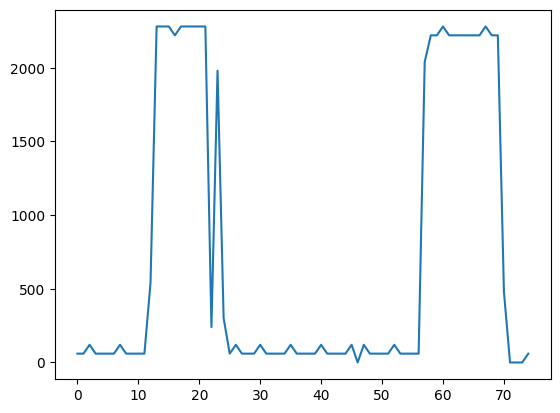

In [18]:
# show the load profile of a dishwasher
with open('process_dishwasher.json', 'r') as file_object:  #open the file in write mode
     process_dishwasher = json.load(file_object) 
total_energy = np.sum(process_dishwasher)/60
plt.plot(process_dishwasher)
print('Total energy needed by the process:', total_energy,'Wh')

In [19]:
def suitability(power,time_point,max_waiting_time,total_energy):
    """
    Determine the suitability of a given time point for running a process with a initially empty battery.

    This function calculates the accumulated energy generation over a specified
    period, starting from the given time point and extending up to a maximum
    waiting time. If the accumulated energy generation is greater than or equal
    to a predefined total energy threshold, the function returns True, indicating
    that the time point is suitable for the process. Otherwise, it returns False.

    Parameters:
        time_point (int): The starting time point to be evaluated.
        max_waiting_time (int): The maximum duration, in time units, for which
                               energy accumulation is considered.

    Returns:
        bool: True if the accumulated energy generation is sufficient for the process,
              False if the accumulated energy generation is insufficient.

    """
    energy = 0  # start with an empty battery
    for i in range(max_waiting_time*6):
        if time_point+i < len(power):
            energy += power[time_point+i]/6
        
    if energy >= total_energy:
        return True
    return False



In [20]:
def count_starting_points(power,max_waiting_time,total_energy):
    """
    Calculate the count of starting points suitable for a process during a period (e.g. a year).

    This function iterates through the power data array (a time series), evaluating the suitability
    of each time point using the suitability() function. If a time point is
    suitable, it increments the count of suitable starting points. The final count
    of suitable starting points is returned as the result.

    
    Parameters:
        max_waiting_time (int): The maximum tolerance to wait, in time units, for which energy accumulation is considered.

    Returns:
        int: The count of time points that are suitable for a process.
    """
    count = 0
    for i in range(len(power)):
        if suitability(power,i,max_waiting_time,total_energy):
            count+=1
    return count

###  test different configuration:
- Max waiting time(in hours), first set it to a large number to do sanity check, and then try out different values.

- Battery capacity, set to a value larger than the total energy needed by the appliance.

- Turbine: one of the best seller backyard wind turbine, Automaxx Windmill 1500W 48V 60A, implemented at height 10m.
<img src="powercurve.png" alt="Italian Trulli" width="400" height="500">

In [21]:
wind_data_dir="../fmidata/windspeed_stations_2021"

In [22]:
def get_fractions_FMI(battery_capacity,total_energy,max_waiting_time):
    """
    Calculate workable fractions of wind energy production based on weather data.

    This function reads wind speed data from CSV files in a data directory comprised of a year wind record, calculates wind power
    production, determines suitable starting points, and computes workable fractions of energy
    production within a certain year.

    Args:
        battery_capacity (float): The capacity of the battery.
        total_energy (float): Total energy needed.
        max_waiting_time (float): Maximum waiting time can be tolerated.

    Returns:
        dict: A dictionary containing workable fractions of wind energy production for each station.
    """
    if total_energy > battery_capacity:
        print('The storage of the battery is not sufficient for your process.')
    else:
        workable_fractions={}
        wind_data_dir="../fmidata/windspeed_stations_2021"
        for file in os.listdir(wind_data_dir):
            if not file.startswith("."):
            # Read weather data from csv
                weather_df = pd.read_csv(os.path.join(wind_data_dir, file))
                weather_df['Wind speed (m/s)'] = weather_df['Wind speed (m/s)'].replace('-',
                                                                                None).astype(float)
                weather_df['Wind speed (m/s)'].interpolate(method='linear', inplace=True)
                weather_df['Wind speed (m/s)'] = weather_df['Wind speed (m/s)'].apply(lambda x: np.maximum(x, 0))

                weather_df = weather_df[['Wind speed (m/s)']]

                column_names = pd.MultiIndex.from_arrays(
                    [['wind_speed'], ['10']], names=['variable_name', 'height'])

                weather_df.columns = column_names
                weather_df['roughness_length','0'] = 0.15
                weather_df.fillna(weather_df.mean(numeric_only=True).round(2), inplace=True) 
                power = speed_to_power(weather_df, my_turbine=my_turbine)
                suitable_starting_points = count_starting_points(power,max_waiting_time,total_energy)
                workable_fractions[file[:-4]] = suitable_starting_points/len(power)
        return workable_fractions

In [23]:
## parameters to test
MAX_WAITING_TIME = 5 # int, unit:hour 
BATTERY_CAPICITY = 2000
workable_fractions = get_fractions_FMI(battery_capacity=BATTERY_CAPICITY,\
                                       total_energy=778,max_waiting_time=MAX_WAITING_TIME)

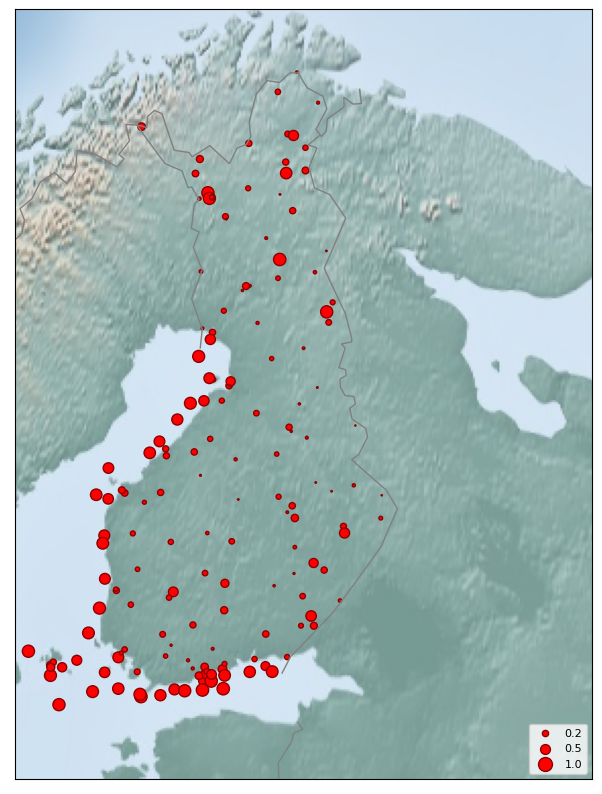

In [24]:
# station coords
stations_Fin = pd.read_csv('FMIcoords.csv')

# use small dummy values for stations without data
dummy_fractions = [0.00001]*stations_Fin.shape[0]
stations_Fin['fraction'] = dummy_fractions


# iter workable fractions for all stations with data
for key, value in workable_fractions.items():    
    stations_Fin.loc[stations_Fin.station == key,
                     'fraction'] = value 
# draw heatmap 
draw_power_map(stations_Fin, country='Finland',indicator='marker_size')